# IMPORT LIBRARY

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Reshape, Add, Multiply, DepthwiseConv2D, Dense
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

# DATASET

Class Distribution in Training Set:
benign_malignant
benign       26035
malignant      465
Name: count, dtype: int64

Class Distribution in Validation Set:
benign_malignant
benign       6507
malignant     119
Name: count, dtype: int64

Age Statistics in Training Set:
count    26444.000000
mean        48.833951
std         14.381341
min         10.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

Sample Training Images:


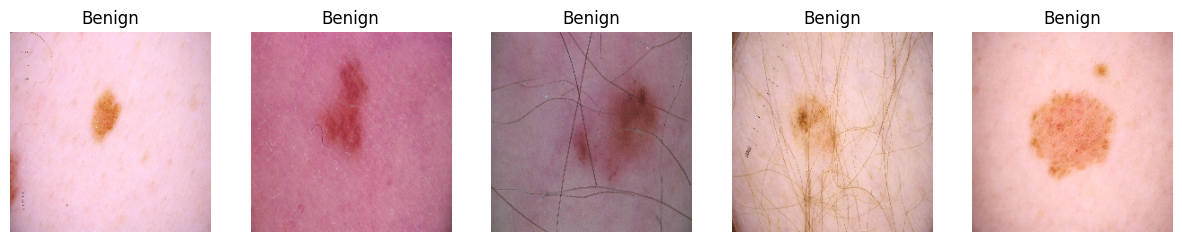

In [45]:
print("Class Distribution in Training Set:")
print(train_metadata['benign_malignant'].value_counts())

print("\nClass Distribution in Validation Set:")
print(val_metadata['benign_malignant'].value_counts())

print("\nAge Statistics in Training Set:")
print(train_metadata['age_approx'].describe())

# Display sample images with labels
def show_sample_images(generator, num_samples=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title('Malignant' if labels[i] == '1' else 'Benign')
        plt.axis('off')
    plt.show()

print("\nSample Training Images:")
show_sample_images(train_generator)

# MODEL


# mobnet my impl

In [71]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the metadata CSV file
metadata_file_path = 'dataset/ISIC2020/train/ISIC_2020_Training_GroundTruth_v2.csv' 
metadata = pd.read_csv(metadata_file_path)

# Define the path to the images
images_folder_path = 'dataset/ISIC2020/train/train_images'

# Add file extension to image names (if not already present)
metadata['image_name'] = metadata['image_name'].apply(lambda x: f"{x}.jpg")

# Map benign and malignant labels to '0' and '1' as strings
metadata['label'] = metadata['benign_malignant'].map({'benign': '0', 'malignant': '1'})

# Split metadata into training and validation sets
train_metadata, val_metadata = train_test_split(metadata, test_size=0.2, random_state=42)

# Define ImageDataGenerator for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale images to [0, 1]
    # Add other augmentation parameters as needed
)

val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_metadata,
    directory=images_folder_path,
    x_col='image_name',
    y_col='label',  # Use 'label' instead of 'benign_malignant'
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  # Since it's binary classification
    shuffle=True  # Shuffle data if needed
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_metadata,
    directory=images_folder_path,
    x_col='image_name',
    y_col='label',  # Use 'label' instead of 'benign_malignant'
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  # Since it's binary classification
    shuffle=False  # No need to shuffle validation data
)

# Print the first few rows of metadata to verify loading (optional)
print(metadata.head())

# Print the first few filenames from train_generator (optional)
print(train_generator.filenames[:10])

# Verify the number of images found
print(f"Found {train_generator.samples} training images and {val_generator.samples} validation images.")

# Perform any additional data preprocessing as needed (scaling, encoding categorical variables)

# Example preprocessing for age (assuming 'age_approx' is a numerical column)
age_scaler = StandardScaler()
metadata['age_approx'] = age_scaler.fit_transform(metadata[['age_approx']])

# Example preprocessing for gender (assuming 'sex' is categorical)
gender_encoder = OneHotEncoder()
gender_encoded = gender_encoder.fit_transform(metadata[['sex']])
metadata = pd.concat([metadata, pd.DataFrame(gender_encoded.toarray(), columns=gender_encoder.get_feature_names_out(['sex']))], axis=1)

# Example preprocessing for anatomical site (assuming 'anatomical_site_general_challenge' is categorical)
position_encoder = OneHotEncoder()
position_encoded = position_encoder.fit_transform(metadata[['anatom_site_general_challenge']])
metadata = pd.concat([metadata, pd.DataFrame(position_encoded.toarray(), columns=position_encoder.get_feature_names_out(['anatom_site_general_challenge']))], axis=1)

# Drop original categorical columns after encoding if needed
metadata.drop(['sex', 'anatom_site_general_challenge'], axis=1, inplace=True)

# Merge image filenames and metadata based on 'image_name' for further analysis
merged_data = pd.merge(pd.DataFrame(train_generator.filenames, columns=['image_name']), metadata, on='image_name')

# Verify the merged data
print(merged_data.head())

Found 26499 validated image filenames belonging to 2 classes.
Found 6626 validated image filenames belonging to 2 classes.
         image_name  patient_id   lesion_id     sex  age_approx  \
0  ISIC_2637011.jpg  IP_7279968  IL_7972535    male        45.0   
1  ISIC_0015719.jpg  IP_3075186  IL_4649854  female        45.0   
2  ISIC_0052212.jpg  IP_2842074  IL_9087444  female        50.0   
3  ISIC_0068279.jpg  IP_6890425  IL_4255399  female        45.0   
4  ISIC_0074268.jpg  IP_8723313  IL_6898037  female        55.0   

  anatom_site_general_challenge diagnosis benign_malignant  target label  
0                     head/neck   unknown           benign       0     0  
1               upper extremity   unknown           benign       0     0  
2               lower extremity     nevus           benign       0     0  
3                     head/neck   unknown           benign       0     0  
4               upper extremity   unknown           benign       0     0  
['ISIC_6933350.jpg', 'IS

/opt/anaconda3/envs/cvproj/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [72]:
class hswish(tf.keras.layers.Layer):
    def __init__(self):
        super(hswish, self).__init__()

    def call(self, inputs):
        return inputs * tf.nn.relu6(inputs + 3) / 6.0
        

class SqueezeAndExcite(Layer):
    def __init__(self, in_size, reduction=4):
        super(SqueezeAndExcite, self).__init__()
        self.avg_pool = GlobalAveragePooling2D()
        self.reshape1 = Reshape((1, 1, in_size))
        self.conv1 = Conv2D(in_size // reduction, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.conv2 = Conv2D(in_size, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn2 = BatchNormalization()
        self.sigmoid = tf.keras.activations.sigmoid
    
    def call(self, x):
        scale = self.avg_pool(x)  # Global average pooling
        scale = self.reshape1(scale)  # Reshape to (batch_size, 1, 1, in_size)
        scale = self.conv1(scale)
        scale = self.bn1(scale)
        scale = self.relu(scale)
        scale = self.conv2(scale)
        scale = self.bn2(scale)
        scale = self.sigmoid(scale)
        return Multiply()([x, scale])  # Element-wise multiplication

class Block(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation=tf.keras.activations.relu, expansion_factor=1, se_ratio=0):
        super(Block, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expansion_factor = expansion_factor
        self.se_ratio = se_ratio
        self.activation = activation
        
        # Calculate expanded channels
        self.expanded_channels = in_channels * expansion_factor
        
        # Layers initialization 
        if self.expansion_factor != 1:
            self.expansion_conv = tf.keras.layers.Conv2D(self.expanded_channels, kernel_size=1, strides=1, padding='valid', use_bias=False)
            self.expansion_bn = tf.keras.layers.BatchNormalization()
        
        self.depthwise_conv = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, padding='same', depth_multiplier=1, use_bias=False)
        self.depthwise_bn = tf.keras.layers.BatchNormalization()
        
        if se_ratio:
            self.squeeze_excitation = SqueezeAndExcite(self.expanded_channels, reduction=int(in_channels * se_ratio))
        
        self.projection_conv = tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.projection_bn = tf.keras.layers.BatchNormalization()
        
        self.shortcut = tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='valid', use_bias=False) if stride > 1 or in_channels != out_channels else None
    
    def call(self, x):
        identity = x
        
        if self.expansion_factor != 1:
            x = self.expansion_conv(x)
            x = self.expansion_bn(x)
            x = self.activation(x)
        
        x = self.depthwise_conv(x)
        x = self.depthwise_bn(x)
        x = self.activation(x)
        
        if self.se_ratio:
            x = self.squeeze_excitation(x)
        
        x = self.projection_conv(x)
        x = self.projection_bn(x)

        if self.shortcut is not None:
            identity = self.shortcut(identity)
        
        x = Add()([x, identity])  
        x = self.activation(x)
        
        return x

In [34]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, GlobalAveragePooling2D, Flatten
# from tensorflow.keras.layers import concatenate

# def model(input_shape=(224, 224, 3), num_classes=1):
#     # Define inputs
#     inputs_image = Input(shape=input_shape, name='image_input')
#     # inputs_age = Input(shape=(1,), name='age_input')
#     # inputs_sex = Input(shape=(3,), name='sex_input')  # Assuming 3 categories (one-hot encoded)
#     # inputs_position = Input(shape=(6,), name='position_input')  # Assuming 6 anatomical site categories (one-hot encoded)
    
#     # # Flatten image input
#     # flattened_image = Flatten()(inputs_image)
    
#     # # Encoder layers for age, sex, and position
#     # age_embedding = tf.keras.layers.Embedding(input_dim=100, output_dim=16)(inputs_age)  # Adjust input_dim based on max age
#     # age_flattened = tf.keras.layers.Flatten()(age_embedding)
#     # sex_dense = tf.keras.layers.Dense(16, activation='relu')(inputs_sex)
#     # position_dense = tf.keras.layers.Dense(32, activation='relu')(inputs_position)
    
#     # Concatenate encoded features with flattened image input
#     #x = concatenate([flattened_image, age_flattened, sex_dense, position_dense])
#     #x = flattened_image
#     # Reshape back to image shape
#     #x = tf.keras.layers.Reshape(target_shape=(224, 224, 3))(x)
    
#     # Initial conv layer
#     x = Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
    
#     x = Block(16, 24, kernel_size=3, stride=2)(x)
#     x = Block(24, 24, kernel_size=3, stride=2)(x)
#     x = Block(24, 40, kernel_size=3, stride=1)(x)
#     x = Block(40, 40, kernel_size=5, stride=2)(x)
#     x = Block(40, 40, kernel_size=5, stride=1)(x)
#     x = Block(40, 80, kernel_size=5, stride=1)(x)
#     x = Block(80, 80, kernel_size=5, stride=1)(x)
#     x = Block(80, 80, kernel_size=5, stride=1)(x)
#     x = Block(80, 112, kernel_size=5, stride=2, se_ratio=0.5)(x)
#     x = Block(112, 112, kernel_size=5, stride=1, se_ratio=0.5)(x)
#     x = Block(112, 160, kernel_size=5, stride=1, activation=hswish, se_ratio=0.5)(x)

    
#     # Global pooling and final dense layers
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1280, activation='relu')(x)
    
#     # Output layer for binary classification
#     outputs = Dense(num_classes, activation='sigmoid')(x)
    
#     # Define model
#     #model = tf.keras.Model(inputs=[inputs_image, inputs_age, inputs_sex, inputs_position], outputs=outputs)
#     model = tf.keras.Model(inputs=[inputs_image], outputs=outputs)
    
#     return model

# # Create an instance of the model
# model = model()

# # Print model summary
# model.summary()


UnboundLocalError: cannot access local variable 'x' where it is not associated with a value

In [73]:
def model(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = hswish()(x)
    
    x = Block(16, 16, kernel_size=3, stride=2)(x)
    x = Block(16, 24, kernel_size=3, expansion_factor= 4, stride=2)(x)
    x = Block(24, 24, kernel_size=3, expansion_factor= 4,stride=1)(x)
    x = Block(24, 40, kernel_size=5, stride=2, expansion_factor= 4, activation=hswish(), se_ratio=1)(x)
    x = Block(40, 40, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(40, 40, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(40, 48, kernel_size=5, stride=1, expansion_factor= 3, activation=hswish(), se_ratio=1)(x)
    x = Block(48, 48, kernel_size=5, stride=1, expansion_factor= 3, activation=hswish(), se_ratio=1)(x)
    x = Block(48, 96, kernel_size=5, stride=2, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(96, 96, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(96, 96, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    
    
    #x = Conv2D(96, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    # x = BatchNormalization()(x)
    # x = hswish()(x)
    # x = Dense(576, activation=None)(x)
    # x = BatchNormalization()(x)
    # x = hswish()(x)
    # x = Dense(1280, activation=None)(x)
    # outputs = Dense(num_classes, activation='sigmoid')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1280, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)  # Example input shape, adjust as per your dataset
model = model(input_shape, num_classes=1)

# Print model summary
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1010 (Conv2D)            │ (None, 112, 112, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1125        │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hswish_116 (hswish)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_237 (Block)               │ (None, 56, 56, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_238 (Block)               │ (None, 28, 28, 24)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_239 (Block)               │ (None, 28, 28, 24)     │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_240 (Block)               │ (None, 14, 14, 40)     │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_241 (Block)               │ (None, 14, 14, 40)     │        31,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_242 (Block)               │ (None, 14, 14, 40)     │        31,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_243 (Block)               │ (None, 14, 14, 48)     │        17,844 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_244 (Block)               │ (None, 14, 14, 48)     │        20,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_245 (Block)               │ (None, 7, 7, 96)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_246 (Block)               │ (None, 7, 7, 96)       │       139,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_247 (Block)               │ (None, 7, 7, 96)       │       139,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_229    │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1280)           │       124,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 588,185 (2.24 MB)

 Trainable params: 572,585 (2.18 MB)

 Non-trainable params: 15,600 (60.94 KB)

In [74]:
early_stopping = EarlyStopping(monitor='loss', 
                               patience=3, 
                               restore_best_weights=True)

history = model.fit(
                train_generator,
                epochs=100,
                validation_data=val_generator,
                callbacks=[early_stopping])

Epoch 1/100


/opt/anaconda3/envs/cvproj/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


829/829 ━━━━━━━━━━━━━━━━━━━━ 922s 1s/step - accuracy: 0.9823 - loss: 0.1077 - val_accuracy: 0.9820 - val_loss: 0.1016
Epoch 2/100
829/829 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - accuracy: 0.9819 - loss: 0.0854 - val_accuracy: 0.9820 - val_loss: 0.0848
Epoch 3/100
829/829 ━━━━━━━━━━━━━━━━━━━━ 911s 1s/step - accuracy: 0.9823 - loss: 0.0818 - val_accuracy: 0.9820 - val_loss: 0.0921
Epoch 4/100
829/829 ━━━━━━━━━━━━━━━━━━━━ 921s 1s/step - accuracy: 0.9828 - loss: 0.0774 - val_accuracy: 0.9820 - val_loss: 0.0953
Epoch 5/100
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9824 - loss: 0.0793